In [1]:
play = False

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18 as cosmo

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

#TIM = p.SpaceTIM
TIM = p.TIM
#TIM = p.TIM2
#GAL = p.AstroDeep
GAL = p.Euclid
CII = l.CII

In [2]:
def quadsum(arr):
    return np.sqrt(np.sum(arr[~np.isnan(arr)]**2))

def galCross_Variance(ngal, numModes, Px, Pg, Pl, Nl):
    crossVar = [(PxG**2 + (NT + PT) * (1/n_gal + Pg)) / (2*nm)
        for n_gal, nm, PxG, Pg, PT, NT in zip(ngal, numModes, Px, Pg, Pl, Nl)]
    return crossVar

In [3]:
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.8

if play:
    dlnk = 1

colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bin_zs = [b.center.value for b in bins]
bands = ['SW', 'SW', 'LW', 'LW'] 

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

In [4]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]


# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=False) 


results = camb.get_results(pars)

binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

nModes = []
for j, (ks,ws) in enumerate(zip(k_mags, windows)):
    kflat = ks.flatten()
    wflat = ws.flatten()
    kNonZero = kflat[np.nonzero(kflat)[0]]
    edges = kbin_edges[j]
    
    nModeList = []
    for i in np.arange(len(edges)-1):
        #print(i, len(edges))
        if i+1 == len(edges):
            wSum = (np.sum(wflat[kflat>edges[i]]))
        else:
            wSum = (np.sum(wflat[(kflat>edges[i]) & (kflat<=edges[i+1])]))
        nModeList.append(wSum/2.) # accounting for double counting.
    nModeList = np.asarray(nModeList)
    nModes.append(np.asarray(nModeList))

window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
b_CII = 1.7 # TODO: Get an actual value for this and Bgal
b_gal = 1.7 # maintaining b* = b_CII*b_gal = 3
Igal = 1
bstar = b_CII*b_gal

C:\Users\juzz\AppData\Local\Temp\ipykernel_20376\1290356114.py:13: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


Note: redshifts have been re-sorted (earliest first)


## Make changes in the cell below

In [52]:
def quadSNR(SWNEI = False, LWNEI = False, numberDensities = [False], area = False, kCut=1):
    '''
    Calculate the quadature sum of SNR(k) for 4 seperate TIM z bins as a function of TIM NEI and galaxy nGal

    SWNEI: Average Noise equivalent intensity of the short wavelength array in u.Jy / (u.s ** .5)
    LWNEI: Average Noise equivalent intensity of the long wavelength array in u.Jy / (u.s ** .5)
    nGal: len 4 arr - Galaxy number density in Mpc**-3 * h**3 per TIM redshift bin in order of lowest to highest z
    area: survey area.This will always generate a square field of view
    with sides of angle sqrt(area) degrees on a side.
            NOTE above values will default to whatever is saved in the props file for TIM if not individually assigned.

    
    kCut: float/int k mode value that establishes the cuttoff between the clustering and shot regimes. 

    returns quad_SNRs: len 4 arr quadature sum of SNR(k) for 4 TIM z bins in order of lowest to highest z
    '''
    #TIM.SW.NEI = SWNEI # These don't actually change the NEI in the noise calculation
    #TIM.LW.NEI = LWNEI
    #print(numberDensities)
    if numberDensities[0]:
        GAL.n_gals = numberDensities
    
    if SWNEI:
        TIM['SW'].ins.NEI = SWNEI
        
    if LWNEI:
        TIM['LW'].ins.NEI = LWNEI
    
    if area:
        TIM.Daz = np.sqrt(area) * u.deg
        TIM.Del = np.sqrt(area) * u.deg
    
    # ***
    #for b, band in zip(bins, bands):
    #    print(TIM[band].ins.NEI)
    
    LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

    x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
    #where fs is SFRD from the catalogue divided by the corresponding madau dickinson curve point.
    PxGs = [(bstar * Icii * Igal * Pm) #+ x_shot 
                for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]


    TIM_shot = [1.2e9,2.2e9,3e9,3e9] # TODO: Discuss a self consistent way of calculating these values.
    P_TIM = [(b_CII**2 * ICII**2 * Pm + shot) for ICII, (_,Pm), shot in zip(Iciis, Pms, TIM_shot)]
    N_TIM = [lsb.cell_noise(TIM.time).value for lsb, nm in zip(LSbins, nModes)]
    #print(N_TIM[0])
    P_gal = [b_gal**2*Pm for (_,Pm), ngal in zip(Pms, GAL.n_gals)]

    VARx = galCross_Variance(GAL.n_gals, nModes, PxGs, P_gal, P_TIM, N_TIM)
    
    inClust = [np.where(ks <= kCut) for ks, _ in Pms]
    inShot = [np.where(ks > kCut) for ks, _ in Pms]

    SNR_Clust = [PxG[clust] / np.sqrt(VARs[clust])  for PxG, VARs, clust in zip(PxGs, VARx, inClust)]
    SNR_Shot = [PxG[shot] / np.sqrt(VARs[shot])  for PxG, VARs, shot in zip(PxGs, VARx, inShot)]
    
    #sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
    quadClust = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_Clust]
    quadShot = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_Shot]
    #quadClust = [quadsum(SNRs) for SNRs in SNR_Clust]
    #quadShot = [quadsum(SNRs) for SNRs in SNR_Shot]
    
    #print(SNR_Clust)
    return quadClust, quadShot

In [60]:
area

NameError: name 'area' is not defined

In [63]:
npoints = 50

#NEIs = np.linspace( 1.191e6, 6.81e7, npoints) * u.Jy / (u.s ** .5)
#nGals = np.linspace(1e-4, 1e-2, npoints)
NEIs = np.logspace(6, 8.5, npoints+1) * u.Jy / (u.s ** .5)
nGals = np.logspace(np.log10(1e-4), np.log10(1e-1), npoints)
calcSNRs = np.zeros((len(NEIs), len(nGals)))
calcShotSNRs = np.zeros((len(NEIs), len(nGals)))

In [64]:
reload(p)
TIM = p.TIM
for k in [0,1,2,3]:
    for i, NEI in enumerate(NEIs):
        for j, n in enumerate(nGals):
            nArray = np.asarray([n,n,n,n])
            #print(n, NEI)
            calcSNRs[i][j] = quadSNR(NEI, NEI, nArray)[0][0]
            calcShotSNRs[i][j] = quadSNR(NEI, NEI, nArray)[0][1]

In [146]:
reload(p)
TIM = p.TIM
areas = np.logspace(-2, 4, npoints)

AcalcSNRs = np.zeros((len(NEIs), len(nGals)))
AcalcShotSNRs = np.zeros((len(NEIs), len(nGals)))

for k in [0,1,2,3]:
    for i, NEI in enumerate(NEIs):
        for j, A in enumerate(areas):
            #AArray = np.asarray([A,A,A,A])
            #print(n, NEI)
            AcalcSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][0]
            AcalcShotSNRs[i][j] = quadSNR(NEI, NEI, area = A)[0][1]

In [135]:
~np.array([True,True])

array([False, False])

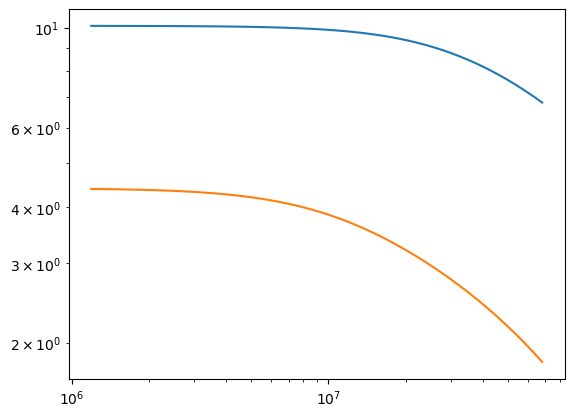

In [19]:
plt.loglog(NEIs, AcalcSNRs[:, 0])
plt.loglog(NEIs, calcSNRs[:, 0])

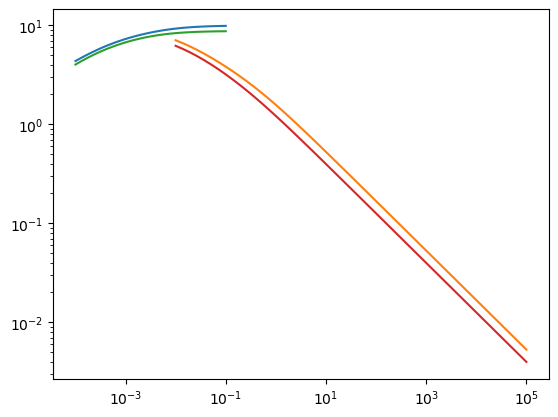

In [31]:
def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

atTIMArea = np.where(areas == closest(areas, 0.2))[0][0]
atTIMnGal = np.where(nGals == closest(nGals, 0.1))[0][0]

plt.loglog(nGals, calcSNRs[atTIMArea, :])
plt.loglog(areas, AcalcSNRs[atTIMnGal, :])

plt.loglog(nGals, calcShotSNRs[atTIMArea, :])
plt.loglog(areas, AcalcShotSNRs[atTIMnGal, :])

In [24]:
atTIMArea

0.19306977288832497

In [92]:
NEIs.shape, nGals.shape, calcSNRs.shape

((51,), (50,), (51, 50))

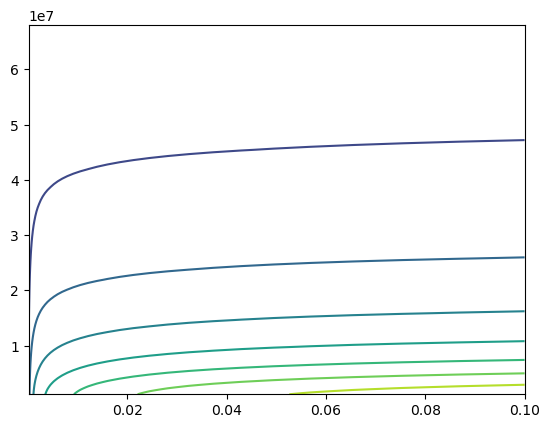

In [93]:
plt.contour(nGals, NEIs, calcSNRs)

In [ ]:
plt.loglog(nGals, calcSNRs[atTIMArea, :])
plt.loglog(areas, calcSNRs[atTIMnGal, :])

In [189]:
BradfordNEIs = np.loadtxt('nei_R250_0p08.txt').T

wavelengths = BradfordNEIs[0]

spaceNEI = BradfordNEIs[3]
TIM2NEI = BradfordNEIs[2]
TIMNEI = BradfordNEIs[1]

inSW = np.where((wavelengths > 240) & (wavelengths < 317))
TIM_SW_NEI = np.mean(TIMNEI[inSW])
TIM2_SW_NEI = np.mean(TIM2NEI[inSW])
TIMS_SW_NEI = np.mean(spaceNEI[inSW])

inLW = np.where((wavelengths > 317) & (wavelengths < 420))
TIM_LW_NEI = np.mean(TIMNEI[inLW])
TIM2_LW_NEI = np.mean(TIM2NEI[inLW])
TIMS_LW_NEI = np.mean(spaceNEI[inLW])


C:\Users\juzz\AppData\Local\Temp\ipykernel_20376\176018932.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e3)


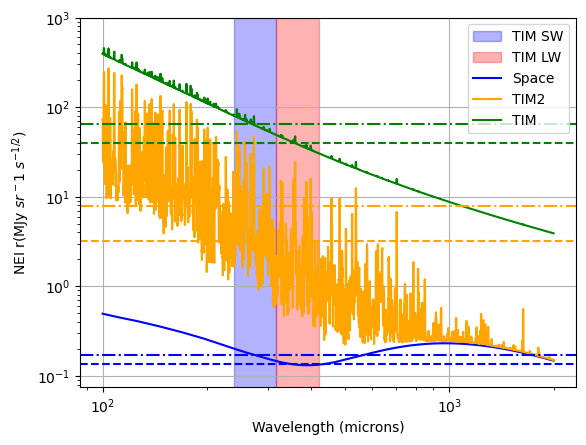

In [195]:
plt.fill_betweenx([0,1e4], [240,240] , [317,317], color = 'blue', alpha = 0.3, label = 'TIM SW')
plt.fill_betweenx([0,1e4], [317,317],  [420,420], color = 'red', alpha = 0.3, label = 'TIM LW')

plt.loglog(wavelengths, spaceNEI, label = 'Space', color = 'b')
plt.loglog(freqs, TIM2NEI, label = 'TIM2', color = 'orange')
plt.loglog(freqs, TIMNEI, label = 'TIM', color = 'green')

plt.axhline(TIM_SW_NEI, ls = '-.', color = 'green')
plt.axhline(TIM_LW_NEI, ls = '--', color = 'green')

plt.axhline(TIM2_SW_NEI, ls = '-.', color = 'orange')
plt.axhline(TIM2_LW_NEI, ls = '--', color = 'orange')

plt.axhline(TIMS_SW_NEI, ls = '-.', color = 'blue')
plt.axhline(TIMS_LW_NEI, ls = '--', color = 'blue')

plt.ylim(0,1e3)

plt.ylabel('NEI r(MJy $sr^-1$ $s^{-1/2})$')
plt.xlabel('Wavelength (microns)')

plt.grid()
plt.legend()

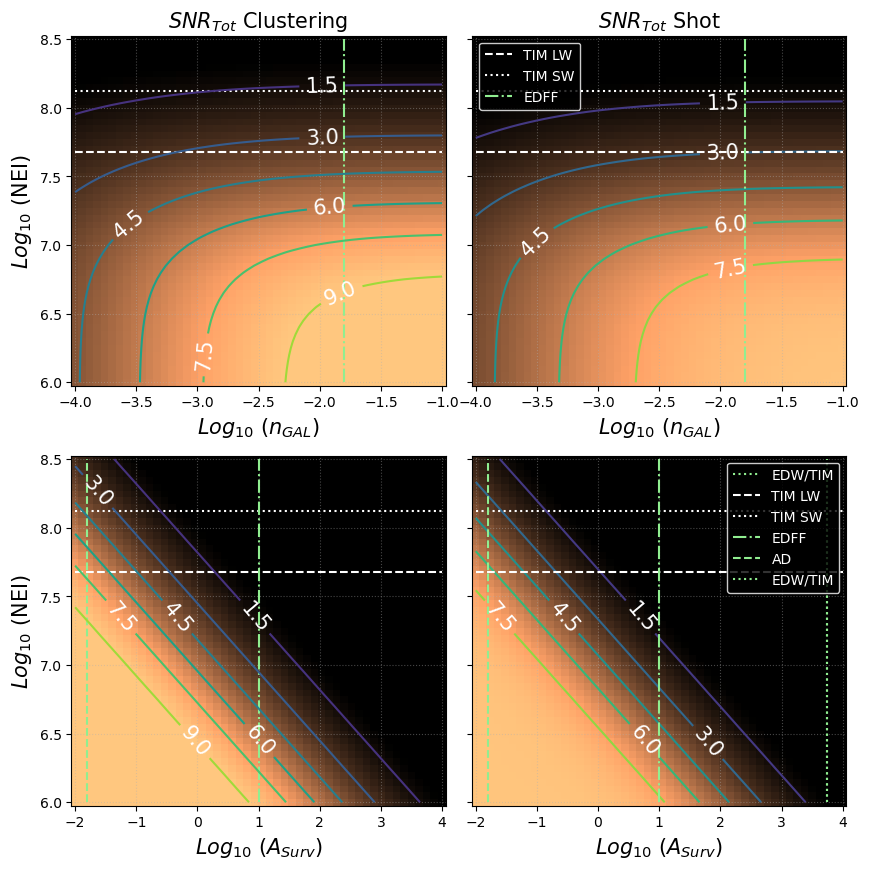

In [197]:
#from matplotlib.ticker import ScalarFormatter

fig, (galNum, ASurv) = plt.subplots(2,2, figsize = (10,10), sharey =True)
#galNum[0].figure(figsize = (5,5), dpi = 200,)

vMin = 1
vMax = 9


#==================================================================================================================
# SURVEY AREA===================+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#==================================================================================================================

#gal Clustering =============
galNum[0].pcolor(np.log10(nGals), np.log10(NEIs.value), calcSNRs, cmap = 'copper',  vmin = vMin, vmax = vMax)

galNum[0].plot([-4,-1], [7.681, 7.681], color = 'white', ls = '--', label = 'TIM LW')
galNum[0].plot([-4,-1], [8.1241, 8.1241], color = 'white', ls = ':', label = 'TIM SW')

#galNum[0].plot([-4,-1], [TIM2_LW_NEI, TIM2_LW_NEI], color = 'cyan', ls = ':', label = 'TIM2 LW')



galNum[0].plot([-1.8,-1.8], [6, 8.5], color = 'lightgreen', ls = '-.', label = 'EDFF')


galNum[0].clabel(galNum[0].contour(np.log10(nGals), np.log10(NEIs.value), calcSNRs), inline=True, fontsize=15, 
           colors = ['white'])

galNum[0].set_xlabel(r'$Log_{10}$ $(n_{GAL})$', fontsize  = 15)
galNum[0].set_ylabel(r'$Log_{10}$ (NEI)', fontsize  = 15)
galNum[0].set_title(r'$SNR_{Tot}$ Clustering', fontsize = 15)
galNum[0].grid(alpha = .4, ls = ':')

#galSHOT ===================

galNum[1].pcolor(np.log10(nGals), np.log10(NEIs.value), calcShotSNRs, cmap = 'copper',  vmin = vMin, vmax = vMax)
galNum[1].clabel(galNum[1].contour(np.log10(nGals), np.log10(NEIs.value), calcShotSNRs), inline=True, fontsize=15,
           colors = ['white'])

galNum[1].plot([-4,-1], [7.681, 7.681], color = 'white', ls = '--', label = 'TIM LW')
galNum[1].plot([-4,-1], [8.1241, 8.1241], color = 'white', ls = ':', label = 'TIM SW')

galNum[1].plot([-1.8,-1.8], [6, 8.5], color = 'lightgreen', ls = '-.', label = 'EDFF')


galNum[1].set_xlabel(r'$Log_{10}$ $(n_{GAL})$', fontsize  =15)
galNum[1].set_title(r'$SNR_{Tot}$ Shot', fontsize = 15)
galNum[1].grid(alpha = .4, ls = ':')


#==================================================================================================================
# SURVEY AREA===================+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#==================================================================================================================

ASurv[0].pcolor(np.log10(areas), np.log10(NEIs.value), AcalcSNRs, cmap = 'copper', vmin = vMin, vmax = vMax)

ASurv[0].plot([-2, 4], [7.681, 7.681], color = 'white', ls = '--', label = 'TIM LW')
ASurv[0].plot([-2, 4], [8.1241, 8.1241], color = 'white', ls = ':', label = 'TIM SW')

ASurv[0].plot([1,1], [6, 8.5], color = 'lightgreen', ls = '-.', label = r'EDFF')
ASurv[0].plot([-1.8,-1.8], [6, 8.5], color = 'lightgreen', ls = '--', label = r'AD}')
ASurv[1].plot([3.75,3.75], [6, 8.5], color = 'lightgreen', ls = ':', label = r'EDW/TIM')




ASurv[0].clabel(ASurv[0].contour(np.log10(areas), np.log10(NEIs.value), AcalcSNRs), inline=True, fontsize=15, 
           colors = ['white'])

ASurv[0].set_xlabel(r'$Log_{10}$ $(A_{Surv})$', fontsize  =15)
ASurv[0].set_ylabel(r'$Log_{10}$ (NEI)', fontsize  =15)
ASurv[0].grid(alpha = .4, ls = ':')

#A Suv SHOT ===================

ASurv[1].pcolor(np.log10(areas), np.log10(NEIs.value), AcalcShotSNRs, cmap = 'copper',  vmin = vMin, vmax = vMax)
ASurv[1].clabel(ASurv[1].contour(np.log10(areas), np.log10(NEIs.value), AcalcShotSNRs), inline=True, fontsize=15,
           colors = ['white'])

ASurv[1].plot([-2,4], [7.681, 7.681], color = 'white', ls = '--', label = 'TIM LW')
ASurv[1].plot([-2,4], [8.1241, 8.1241], color = 'white', ls = ':', label = 'TIM SW')

ASurv[1].plot([1,1], [6, 8.5], color = 'lightgreen', ls = '-.', label = r'EDFF')
ASurv[1].plot([-1.8,-1.8], [6, 8.5], color = 'lightgreen', ls = '--', label = r'AD')
ASurv[1].plot([3.75,3.75], [6, 8.5], color = 'lightgreen', ls = ':', label = r'EDW/TIM')


ASurv[1].set_xlabel(r'$Log_{10}$ $(A_{Surv})$', fontsize  =15)
ASurv[1].grid(alpha = .4, ls = ':')

gl = galNum[1].legend(loc = 'upper left')
for text in gl.get_texts():
    text.set_color("white")
gframe = gl.get_frame()
gframe.set_color('black')
gframe.set_edgecolor('white')

Al = ASurv[1].legend(loc = 'upper right')
for text in Al.get_texts():
    text.set_color("white")
Aframe = Al.get_frame()
Aframe.set_color('black')
Aframe.set_edgecolor('white')


fig.subplots_adjust(hspace=None, wspace=.07)

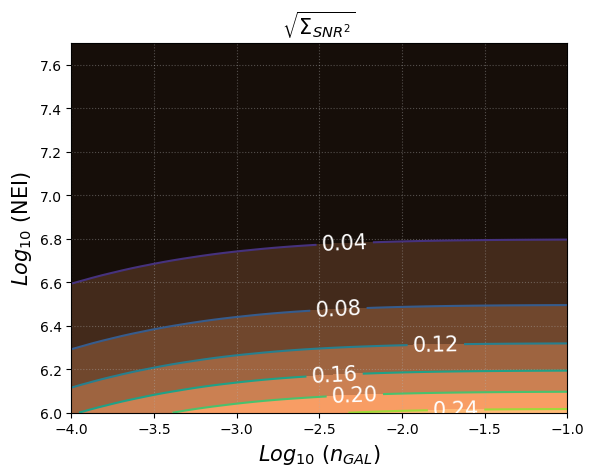

In [59]:
plt.contourf(np.log10(nGals), np.log10(NEIs.value), calcShotSNRs, cmap = 'copper')
plt.clabel(plt.contour(np.log10(nGals), np.log10(NEIs.value), calcShotSNRs), inline=True, fontsize=15, 
           colors = ['white'])

plt.xlabel(r'$Log_{10}$ $(n_{GAL})$', fontsize  =15)
plt.ylabel(r'$Log_{10}$ (NEI)', fontsize  =15)
plt.title(r'$\sqrt{\Sigma_{SNR^2}}$', fontsize = 15)
plt.grid(alpha = .4, ls = ':')


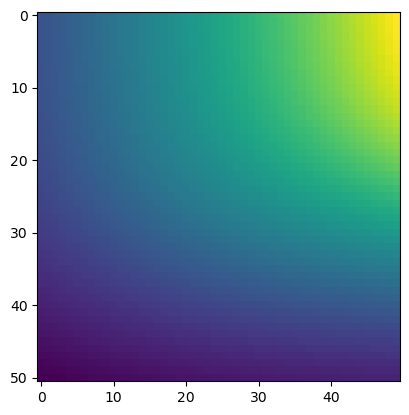

In [14]:
plt.imshow(calcSNRs)


In [ ]:
calcSNRs

In [ ]:
nGalList = np.logspace(-5, -2, 50)
SNRx_as_nGal = np.zeros(len(nGalList))

for i,n in enumerate(nGalList):
    x_shot = fs * Iciis[2] / n # cross shot for TIMxGal
    Pcross = (bstar * Iciis[2] * Igal * Pms[2][1]) + x_shots[2]
    
    VARxTIM = (Pcross**2 + (N_TIM[2] + P_TIM[2]) * (1/n +P_gal[2])) / (2*nModes[2])
    
    SNRx_as_nGal[i] = quadsum(Pcross / np.sqrt(VARxTIM))

In [ ]:
quad_SNRs